In [1]:
from infre.models import SetBased, GSB, GSBWindow, PGSB, PGSBW, ConGSB, ConGSBWindow
from numpy import mean
from networkx import to_numpy_array
from infre.preprocess import Collection
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import SpectralEmbedding
import numpy as np

C:\Users\gkont\AppData\Local\Temp\ipykernel_10620\2445639190.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)


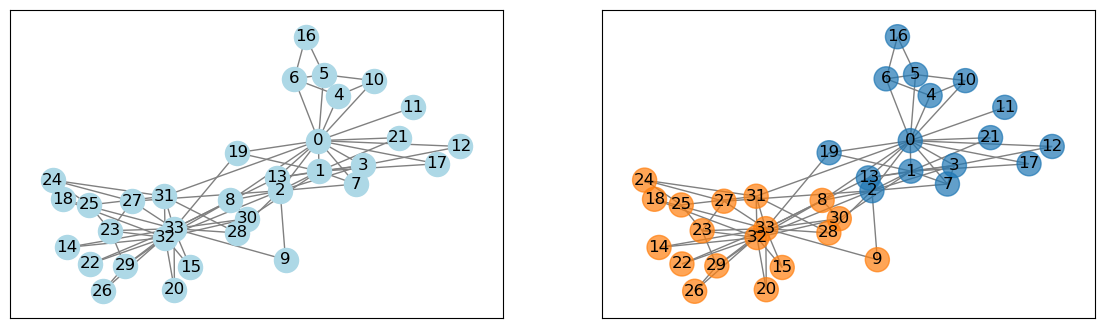

In [10]:
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler

# Create Karate Club graph
G = nx.karate_club_graph()

# Prepare adjacency matrix
adj_matrix = nx.adjacency_matrix(G)

# Spectral Clustering
sc = SpectralClustering(n_clusters=2, affinity='precomputed', n_init=100, assign_labels='discretize')
labels = sc.fit_predict(adj_matrix)

# Plot original graph
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')

labels = sc.labels_

# Map labels to colors with alpha values
colors_map = {
    0: '#1f77b4B3',  # blue with 70% opacity (B3 in hex is ~0.7 in decimal)
    1: '#ff7f0eB3'   # orange with 70% opacity
}
node_colors = [colors_map[label] for label in labels]

# Plot clustered graph
plt.subplot(1, 2, 2)
nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, edge_color='gray')
plt.show()

In [2]:
path = 'collections/CF/docs'

# create collection
col = Collection(path).create(first=-1)

# load queries, relevant documents
queries, rels = Collection.load_qd('collections/CF')

Collection Done! 1239 documents were parsed.


In [3]:
########## GRAPHICAL SET BASED ####################
gsb_model = GSB(col).fit(queries)
pre, rec = gsb_model.evaluate(rels)

print(f'GSB: {mean(pre):.3f}, {mean(rec):.3f}')
G = gsb_model.graph

Query 1/100: len = 7, frequent = 85
Query 2/100: len = 11, frequent = 250
Query 3/100: len = 7, frequent = 100
Query 4/100: len = 5, frequent = 24
Query 5/100: len = 3, frequent = 7
Query 6/100: len = 13, frequent = 287
Query 7/100: len = 9, frequent = 100
Query 8/100: len = 7, frequent = 37
Query 9/100: len = 7, frequent = 51
Query 10/100: len = 6, frequent = 63
Query 11/100: len = 6, frequent = 20
Query 12/100: len = 9, frequent = 121
Query 13/100: len = 6, frequent = 33
Query 14/100: len = 10, frequent = 224
Query 15/100: len = 4, frequent = 10
Query 16/100: len = 10, frequent = 234
Query 17/100: len = 9, frequent = 123
Query 18/100: len = 8, frequent = 65
Query 19/100: len = 7, frequent = 98
Query 20/100: len = 8, frequent = 116
Query 21/100: len = 9, frequent = 51
Query 22/100: len = 5, frequent = 26
Query 23/100: len = 7, frequent = 50
Query 24/100: len = 5, frequent = 9
Query 25/100: len = 7, frequent = 53
Query 26/100: len = 3, frequent = 7
Query 27/100: len = 8, frequent = 31


=> Query 94/100, precision = 0.308, recall = 0.512
=> Query 95/100, precision = 0.314, recall = 0.556
=> Query 96/100, precision = 0.332, recall = 0.542
=> Query 97/100, precision = 0.211, recall = 0.545
=> Query 98/100, precision = 0.131, recall = 0.533
=> Query 99/100, precision = 0.602, recall = 0.600
=> Query 100/100, precision = 0.297, recall = 0.545
GSB: 0.200, 0.524


In [4]:
adj_matrix = nx.to_numpy_array(G)
embeddings = SpectralEmbedding(n_components=50, affinity='precomputed').fit_transform(adj_matrix)
embeddings.shape

(9624, 50)

In [11]:
# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Flatten the matrix into a 1D array
similarity_values = similarity_matrix.flatten()

In [6]:
# plt.hist(similarity_values, bins=n_bins, edgecolor='black')
# plt.title('Distribution of Cosine Similarity Values')
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# Get the Laplacian matrix of the graph
L = nx.normalized_laplacian_matrix(G).todense()

# Compute the eigenvalues and eigenvectors
eigvals, eigvecs = eigh(L)

# Sort the eigenvalues
eigvals = np.sort(eigvals)

# Compute the differences between consecutive eigenvalues
gaps = np.diff(eigvals)

# The number of clusters is the position of the maximum gap, plus one
dims = np.argmax(gaps) + 1

# Use the eigenvectors corresponding to the two smallest non-zero eigenvalues to create 2D embeddings
embeddings = np.array(eigvecs[:, 1:dims])

In [7]:
n_bins = int(np.sqrt(len(similarity_values)))

# Get the histogram bins and frequencies
freq, bins = np.histogram(similarity_values, bins=n_bins)

# Find the index of the bin with the lowest frequency
min_freq_idx = np.argmin(freq)

# The bin with the lowest frequency is then (bins[min_freq_idx], bins[min_freq_idx + 1])
print(f"The bin with the lowest frequency is ({bins[min_freq_idx]}, {bins[min_freq_idx + 1]})")
threshold = np.mean([bins[min_freq_idx], bins[min_freq_idx + 1]])
threshold

The bin with the lowest frequency is (-0.6649257117881746, -0.6647526965422234)


-0.6648392041651989

In [14]:
from sklearn.cluster import KMeans
labels = KMeans(n_clusters=50).fit_predict(embeddings)

C:\Users\gkont\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
from sklearn.decomposition import PCA

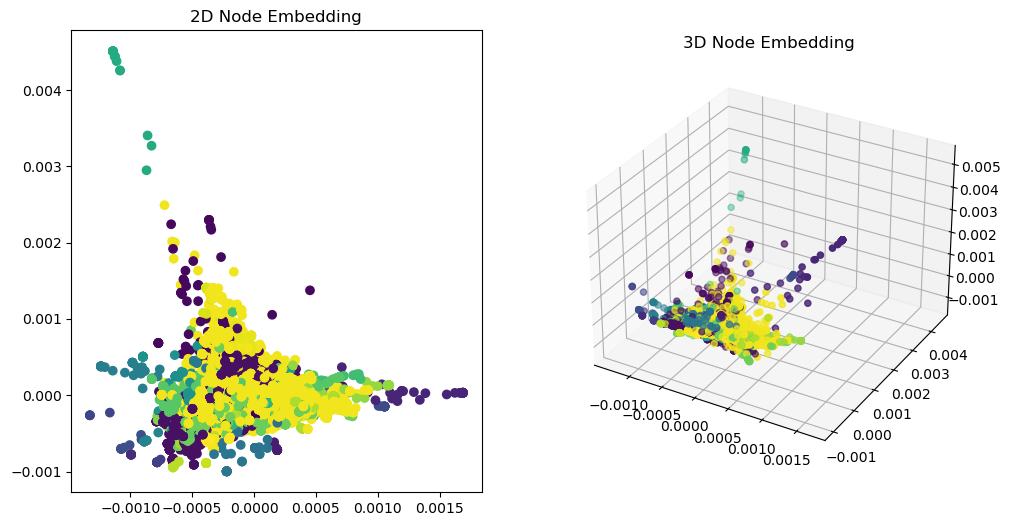

In [15]:
# Create subplots
fig = plt.figure(figsize=(18, 6))  # Adjust size as needed

# Draw the 2D embeddings
ax1 = fig.add_subplot(131)
ax1.scatter(embeddings[:, 0], embeddings[:, 1], c=labels)
ax1.title.set_text('2D Node Embedding')

# Draw the 3D embeddings
ax3 = fig.add_subplot(132, projection='3d')
scatter = ax3.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=labels)
ax3.title.set_text('3D Node Embedding')

In [16]:
embeddings_eigengap = embeddings[:, :3]
embeddings_eigengap.shape

(9624, 3)

In [17]:
labels = KMeans(n_clusters=50).fit_predict(embeddings_eigengap)

C:\Users\gkont\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


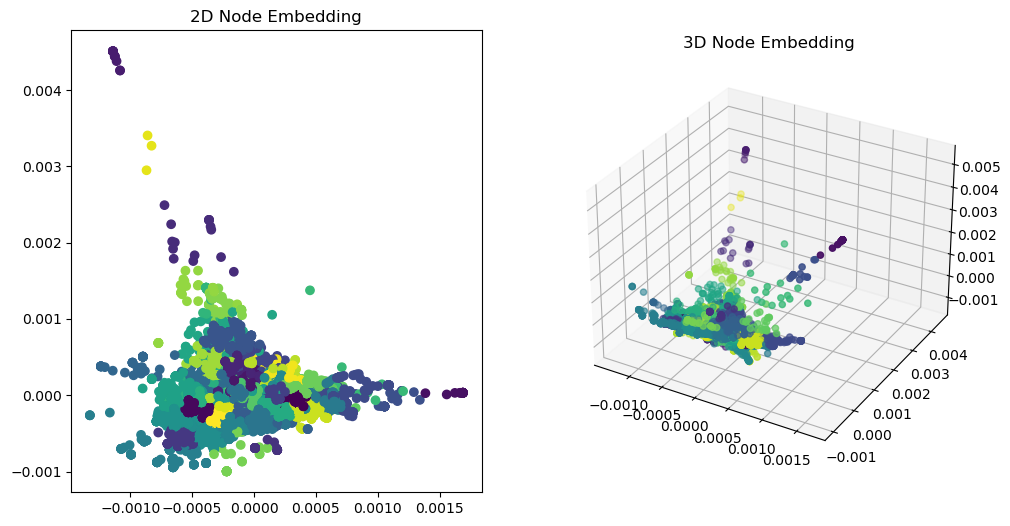

In [18]:
# Create subplots
fig = plt.figure(figsize=(18, 6))  # Adjust size as needed

# Draw the 2D embeddings
ax1 = fig.add_subplot(131)
ax1.scatter(embeddings_eigengap[:, 0], embeddings_eigengap[:, 1], c=labels)
ax1.title.set_text('2D Node Embedding')

# Draw the 3D embeddings
ax3 = fig.add_subplot(132, projection='3d')
scatter = ax3.scatter(embeddings_eigengap[:, 0], embeddings_eigengap[:, 1], embeddings_eigengap[:, 2], c=labels)
ax3.title.set_text('3D Node Embedding')

In [10]:
# ####### PRUNED GRAPHICAL SET BASED ####################  
# pgsb_model = PGSB(col, clusters=110, condition={'sim': -0.664}).fit(queries)
# pre, rec = pgsb_model.evaluate(rels)
# print(f'PGSB: {mean(pre):.3f}, {mean(rec):.3f}')

In [4]:
####### CONCEPTUALIZED GRAPHICAL SET BASED ####################  .226 (raw queries)
con_gsb_model = ConGSB(col, clusters=70, cond={'sim': -0.664}).fit(queries)
pre, rec = con_gsb_model.evaluate(rels)
print(f'CGSB: {mean(pre):.3f}, {mean(rec):.3f}')

71.88306191765439 % pruning. 1351945 edges were pruned out of 1880756.
Query 1/100: len = 7, frequent = 85
Query 2/100: len = 11, frequent = 250
Query 3/100: len = 7, frequent = 100
Query 4/100: len = 5, frequent = 24
Query 5/100: len = 3, frequent = 7
Query 6/100: len = 13, frequent = 287
Query 7/100: len = 9, frequent = 100
Query 8/100: len = 7, frequent = 37
Query 9/100: len = 7, frequent = 51
Query 10/100: len = 6, frequent = 63
Query 11/100: len = 6, frequent = 20
Query 12/100: len = 9, frequent = 121
Query 13/100: len = 6, frequent = 33
Query 14/100: len = 10, frequent = 224
Query 15/100: len = 4, frequent = 10
Query 16/100: len = 10, frequent = 234
Query 17/100: len = 9, frequent = 123
Query 18/100: len = 8, frequent = 65
Query 19/100: len = 7, frequent = 98
Query 20/100: len = 8, frequent = 116
Query 21/100: len = 9, frequent = 51
Query 22/100: len = 5, frequent = 26
Query 23/100: len = 7, frequent = 50
Query 24/100: len = 5, frequent = 9
Query 25/100: len = 7, frequent = 53
Qu

=> Query 92/100, precision = 0.314, recall = 0.505
=> Query 93/100, precision = 0.126, recall = 0.528
=> Query 94/100, precision = 0.295, recall = 0.512
=> Query 95/100, precision = 0.287, recall = 0.556
=> Query 96/100, precision = 0.273, recall = 0.542
=> Query 97/100, precision = 0.366, recall = 0.545
=> Query 98/100, precision = 0.125, recall = 0.533
=> Query 99/100, precision = 0.602, recall = 0.600
=> Query 100/100, precision = 0.310, recall = 0.545
CGSB: 0.242, 0.524


In [4]:
from infre.helpers.functions import draw_clusters

AttributeError: module 'matplotlib' has no attribute 'show'

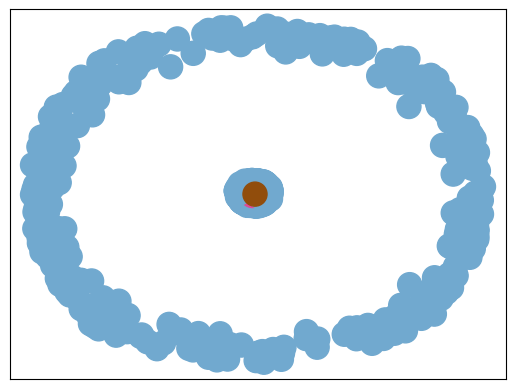

In [5]:
draw_clusters(con_gsb_model.graph)

In [ ]:
####### CONCEPTUALIZED GRAPHICAL SET BASED ####################  .226 (raw queries)
pre, rec = ConGSB(col, clusters=110, cond={'sim': -0.664}).fit_evaluate(queries, rels)
print(f'CGSB-query expansion: {mean(pre):.3f}, {mean(rec):.3f}')

In [13]:
Gprime = con_gsb_model.graph
adj_matrix2 = nx.to_numpy_array(Gprime)

In [16]:
from sklearn.cluster import SpectralClustering
pre_pruning = con_gsb_model.embeddings['labels']
post_pruning = SpectralClustering(n_clusters=110, affinity='precomputed').fit_predict(adj_matrix2)

C:\Users\gkont\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [19]:
# Number of clusters
pre_pruning = pre_pruning.values
n_clusters = len(np.unique(pre_pruning))

diff_counts = np.zeros(n_clusters, dtype=int)

for i in range(len(pre_pruning)):
    if pre_pruning[i] != post_pruning[i]:
        diff_counts[pre_pruning[i]] += 1
        
print(f"Number of nodes that changed clusters per cluster: {diff_counts}")

Number of nodes that changed clusters per cluster: [  21  477    8   16    4   10    5   11    8   13   12    9    0   10
   12    9   12   10   30   11   25   12   13   19   23 5521   31   11
   15   12   16   29   17   13   10   15   18    8    5   12   10   36
   11   23   17   20   16   18    4   14   19   12   19   16   21   18
   25   14   12  278   32   11   35   13   27   13    8   22    7   18
   19   30   28   20   28    9   12   18    8   16   16   18   63    6
   10   14    9   29    5    9   32   10   35   76  787   22   72  152
   27   10   71   24   28   38   37    9  186   14   60  182]


In [ ]:
# Figure size
plt.figure(figsize=(18, 9)) 
# Draw the graph, colored by the cluster labels
nx.draw_networkx(G, node_color=post_pruning, with_labels=False)
plt.show()